# 멋진 작사가 만들기

RNN을 이용해서 여러 가사를 학습시킨 모델로 새로운 가사를 만들어보자.

## 0. 모듈 import

In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import os, re 
import numpy as np
import tensorflow as tf

## 1. 데이터 다운로드


미리 준비된 데이터를 사용한다.

## 2. 데이터 읽어오기
glob로 모든 파일을 읽어서 하나의 리스트에 넣는다.

In [2]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/Exploration/E04_MakeLyricist/data/*'

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in glob.glob(txt_file_path):
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print(f"데이터 크기: {len(raw_corpus)}")

데이터 크기: 187088


데이터가 잘 로드 됐는지 확인해보자.

In [3]:
print("Examples:\n", raw_corpus[:3])

Examples:
 ['The first words that come out', 'And I can see this song will be about you', "I can't believe that I can breathe without you"]


## 3. 데이터 정제

### 정규화를 통한 전처리

정규화를 통해 필요없는 특수문자등을 제거하자.

그리고 너무 긴 문장은 노래가사에 어울리지 않을 수 있고,  
나머지 데이터의 0 padding이 너무 많아 지므로 15개이상의 토큰을 가질 경우 제거하자.

In [4]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

In [5]:
corpus = []
words = set()

for sentence in raw_corpus:
    if len(sentence.strip()) == 0: # 문자가 아예 없거나 공백으로 채워져있으면 제외
        continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    
    token = preprocessed_sentence.split()
    words.update(token)
    if len(token) > 15: # 문자가 15개를 넘으면 제외한다.
        continue
    
    corpus.append(preprocessed_sentence)
        
#corpus[0:10] # 전처리를 거친 데이터 10개만 출력
print(f"사용된 총 단어 개수 {len(words)}")

사용된 총 단어 개수 27621


## 4. 평가 데이터셋 분리

전처리된 데이터를 통해 학습 데이터셋과 테스트 데이터셋을 만들어보자.

### 데이터 토큰화

In [6]:
def tokenize(corpus, num_words):
    # num_words 만큼 단어를 기억할 수 있는 tokenizer를 생성
    # num_words 단어에 포함되지 못한 단어는 '<unk>' 대체
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, filters=' ', oov_token="<unk>")
    
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    return tensor, tokenizer

현재 모든 문장에서 사용된 총 단어 개수는 27621개이다.  
거의 사용되지 않는 단어를 제외하고, 많이 사용하는 순서대로  
절반쯤인 13000개의 단어를 저장하였다.

In [7]:
tensor, tokenizer = tokenize(corpus, 13000) # 단어장의 크기는 13000

src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10:
        break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


가장 많이 사용된 글자는 pad와 start, end를 제외하면 i , the you 순이다.

### 데이터 분리

sklearn의 train_test_split을 사용해서 학습데이터와 테스트데이터로 분리하자.

In [8]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=7)

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124960, 14)
Target Train: (124960, 14)


### Dataset만들기
문자가 토큰화되어 숫자로 바뀐 tensor를 이용하여 학습시킬 데이터 셋을 만들자.

In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 13000개와, 여기 포함되지 않은 0:<pad>를 포함하여 13001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# 테스트 데이터셋 만들기
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.batch(BATCH_SIZE)


## 5. 인공지능 만들기
이제 준비된 데이터셋을 모델을 만들어 학습시켜보자.

### 모델 구성
기존의 LSTM의 2층 짜리 레이어는 오차가 잘 줄지 않아, Bidirectional을 사용하여  
양방향으로 학습하는 모델을 구성하였다.

CuDNN 커널을 사용하기 위해 활성화 함수는 'tanh'를 사용하였다.  
CuDNN 커널을 사용하기 위한 사양은 다음 공식사이트에서 확인가능하다.  
https://www.tensorflow.org/guide/keras/rnn?hl=ko#%EC%84%B1%EB%8A%A5_%EC%B5%9C%EC%A0%81%ED%99%94_%EB%B0%8F_cudnn_%EC%BB%A4%EB%84%90

그리고 batchnormal를 사용하여 overfiting을 어느정도 방지하고, dropout을 대체하였다.

In [10]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        forward_layer = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        backward_layer = tf.keras.layers.LSTM(hidden_size, activation='tanh',
                                             return_sequences=True, go_backwards=True)
        self.rnn = tf.keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer)
        self.batchnormal = tf.keras.layers.BatchNormalization()
        self.linear = tf.keras.layers.Dense(vocab_size)
        
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn(out)
        out = self.batchnormal(out)
        out = self.linear(out)
        
        return out

### 하이퍼 파라미터 설정
데이터의 양이 많아진 만큼 임베딩 사이즈와 히든레이어를 좀 더 키웠다.

In [11]:
embedding_size = 512
hidden_size = 2048
epochs=10

학습 과정에서 loss값 외에도 accuracy를 확인하려고 추가해 보았는데,  
학습 속도가 너무 느려져서 그냥 빼버렸다.

In [12]:
print(f"gpu를 사용 : {tf.config.list_physical_devices('GPU')}")

lyricist = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

lyricist.compile(loss=loss, optimizer=optimizer)

gpu를 사용 : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
for src_sample, tgt_sample in train_dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
lyricist(src_sample)
lyricist.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6656512   
_________________________________________________________________
bidirectional (Bidirectional multiple                  41959424  
_________________________________________________________________
batch_normalization (BatchNo multiple                  16384     
_________________________________________________________________
dense (Dense)                multiple                  53265097  
Total params: 101,897,417
Trainable params: 101,889,225
Non-trainable params: 8,192
_________________________________________________________________


### 학습 시키기

In [14]:
hist = lyricist.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/10
488/488 [==============================] - 605s 1s/step - loss: 2.0547 - val_loss: 0.6879
Epoch 2/10
488/488 [==============================] - 603s 1s/step - loss: 0.0170 - val_loss: 0.0318
Epoch 3/10
488/488 [==============================] - 603s 1s/step - loss: 0.0023 - val_loss: 0.0270
Epoch 4/10
488/488 [==============================] - 602s 1s/step - loss: 0.0010 - val_loss: 0.0277
Epoch 5/10
488/488 [==============================] - 603s 1s/step - loss: 8.4181e-04 - val_loss: 0.0277
Epoch 6/10
488/488 [==============================] - 675s 1s/step - loss: 0.0015 - val_loss: 0.0315
Epoch 7/10
488/488 [==============================] - 1551s 3s/step - loss: 0.0028 - val_loss: 0.0320
Epoch 8/10
488/488 [==============================] - 1547s 3s/step - loss: 0.0037 - val_loss: 0.0266
Epoch 9/10
488/488 [==============================] - 1545s 3s/step - loss: 0.0022 - val_loss: 0.0203
Epoch 10/10
488/488 [==============================] - 1542s 3s/step - loss: 0.0011 

### 학습결과 확인
학습한 모델을 저장하여 나중에 확인 가능하게 만들었다.

그리고 학습동안의 loss를 그래프로 그려보자.

모델을 저장하였습니다. 위치 : /aiffel/aiffel/lyricist/model/lyricist_512_2048_10(1).h5


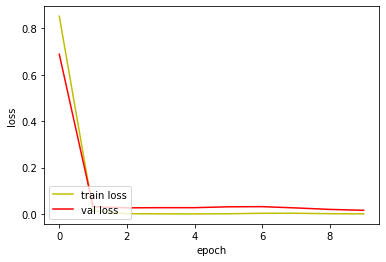

<Figure size 432x288 with 0 Axes>

In [16]:
def create_save_path(forder_path, filename):
    file_path = f'{forder_path}/{filename}'
    uniq = 1
    while os.path.exists(file_path + '.h5'):
        file_path = f'{forder_path}/{filename}({uniq})'
        uniq += 1
    return file_path

forder_path = os.getenv('HOME')+'/aiffel/lyricist/model'
filename = f'lyricist_{embedding_size}_{hidden_size}_{epochs}'
save_file_path = create_save_path(forder_path, filename)

# rnn등의 한방향 sequence가 아닌 모델에는 model.save가 안되서 weight로 저장
lyricist.save_weights(save_file_path +'.h5')
print(f"모델을 저장하였습니다. 위치 : {save_file_path}.h5")
    
plt.plot(hist.history['loss'], 'y', label='train loss')
plt.plot(hist.history['val_loss'], 'r', label='val loss')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(loc='upper left')
plt.legend(loc='lower left')

plt.show()
plt.savefig(save_file_path + '.png')  # 나중에 확인가능하게 학습 그래프를 이미지로 같은 이름으로 저장한다.

## 6. 가사 생성하기
학습한 모델로 부터 노래 가사를 생성해보자.

다음은 모델로 부터 시작 단어를 받아서 문장을 완성키는 함수이다.

In [17]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

i love 다음으로 어떤 가사가 생성될 지 확인해보자.

In [22]:
generate_text(lyricist, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love to steal the tear like an speaking turn up <end> '

'i love to steal the tear like an speaking turn up' 라는 말이 나왔는데,  
솔직히 영어를 잘 못해서 제대로 나온건지 알 수가없다.

## 7. 회고

RNN을 통해 문장을 생성하는 기본적인 내용을 해보았다.  
아직 토큰화된 문자열을 임베딩하는 과정이나 RNN이 되는 원리를  
정확하게 파악하지 못 한것 같다.

다만 토큰화된 단어들을 추상적인 과정으로 표현된다는 것에서  
여러 의미로 자연어 처리에 대한 전반적인 과정을 어느정도 이해한 것 같기도하다.

나중에라도 자연어 처리에 대한 전반적인 공부를 해야할 것 같다.